# False Positive Brand Classifier - EDA & Feature Engineering

This notebook focuses on exploratory data analysis and feature engineering for the FP classifier. It compares multiple feature engineering approaches and exports the best transformer for use in model selection.

## Objective
Develop feature engineering pipeline that can distinguish between articles that genuinely mention sportswear brands vs false positives (e.g., "Puma" the animal, "Patagonia" the region).

**Key Insight: This is a recall-focused problem.**
- **Missing a real sportswear article (low recall) = BAD** - we lose the article forever
- **Letting through a false positive (low precision) = OK** - LLM can catch it later

We optimize for **F2 score** which weights recall 2x higher than precision.

## Contents
1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis) (ALL DATA - for stratification)
4. [Data Preprocessing & Split](#3-data-preprocessing--split)
5. [Exploratory Data Analysis](#4-exploratory-data-analysis) (TRAINING DATA ONLY)
6. [Feature Engineering Comparison](#5-feature-engineering-comparison)
7. [Pipeline Export](#6-pipeline-export)
8. [Summary](#7-summary)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.fp1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.fp1_nb.preprocessing import (
    clean_text,
    create_text_features,
    SPORTSWEAR_VOCAB,
)
from src.fp1_nb.feature_transformer import FPFeatureTransformer

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'is_sportswear'
LABEL_NAMES = ['Not Sportswear (FP)', 'Sportswear']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the FP training data
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
df = load_jsonl_data(DATA_PATH)

Loaded 971 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 6.78 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,is_sportswear,source,fp_reason
0,4c227d4f-e315-4ff6-bc91-fef52fd8e732,MM6 Maison Margiela x Salomon XT - MM6 & ACS Pro Fall 2025 Release Date,"Ever since their debut collaboration in 2022 featuring the Rihanna-approved Cross Low model, MM6...",[Salomon],1,skipped,NaN
1,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],1,labeled,NaN
2,485e193a-3f30-4f1c-855e-a947681b2cbf,Tracy McGrady Says Kobe Leaving Adidas Helped Him Get a Bigger Deal | The Complex Sneakers Podcast,"Complex's\n\nThe Complex Sneakers Show\n\nSeason 17\n\nDecember 12, 2025\n\nTracy McGrady Says K...",[Adidas],1,skipped,NaN
3,10e8ecbc-0625-4aaa-b5f4-e0f4ae02527c,Where to buy Nike Air Force 1 07 Mid Flax sneakers releasing Oct . 8,"Your favorite Nike street style shoes are getting a refresh that’ll add a crisp, neutral look to...",[Nike],1,skipped,NaN
4,04a3817e-38c5-4b62-a678-6eaf49a458c5,"Prime Day competitor sales : The best deals from Walmart , Wayfair , Lululemon and other Amazon ...","As a participant in multiple affiliate marketing programs, Localish will earn a commission for c...",[Lululemon],1,skipped,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     971 non-null    object
 1   title          971 non-null    object
 2   content        971 non-null    object
 3   brands         971 non-null    object
 4   is_sportswear  971 non-null    int64 
 5   source         971 non-null    object
 6   fp_reason      130 non-null    object
dtypes: int64(1), object(6)
memory usage: 53.2+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id         0
title              0
content            0
brands             0
is_sportswear      0
source             0
fp_reason        841
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           609
skipped           232
false_positive    130
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 971

Class distribution:
  Not Sportswear (FP): 130 (13.4%)
  Sportswear: 841 (86.6%)

Imbalance ratio: 6.47:1

[WARNING] Dataset is imbalanced (ratio >= 5.0)
Consider using:
  - Stratified sampling for train/val/test splits
  - Class weights or oversampling/undersampling
  - Appropriate metrics (PR-AUC, F1) over accuracy


Figure saved to images/fp_target_distribution.png


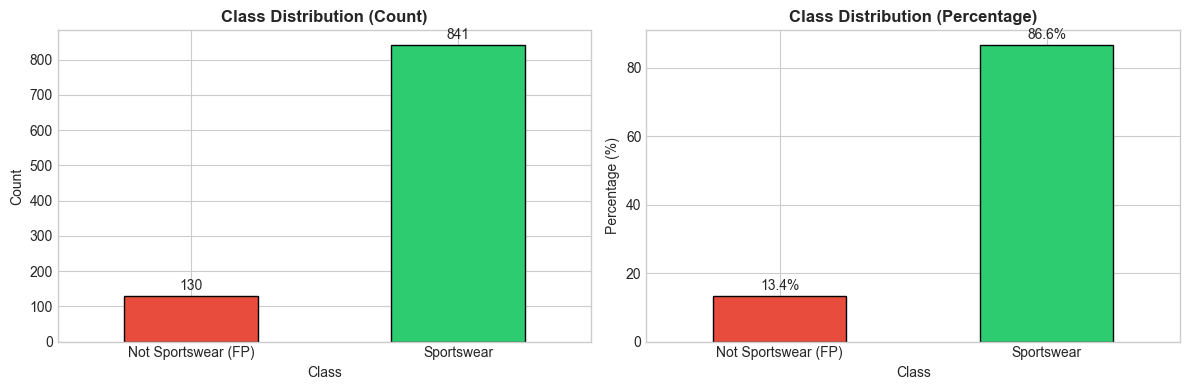

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/fp_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, and content into a single cleaned text field
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners tweaking...

Records with empty text features: 0


In [9]:
# Split with stratification

train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 971

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      582 (59.9%)
  Validation: 194 (20.0%)
  Test:       195 (20.1%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 86.6%, 0: 13.4%
  Val: 1: 86.6%, 0: 13.4%
  Test: 1: 86.7%, 0: 13.3%

Dataset sizes:
  Train: 582 samples
  Val:   194 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 582

Overall statistics:
  Character length: mean=3453, median=2490, range=[140, 24188]
  Word count: mean=556, median=400, range=[22, 4291]

By is_sportswear:
  Class 1:
    Chars: mean=3378, median=2460
    Words: mean=545, median=397
  Class 0:
    Chars: mean=3943, median=2760
    Words: mean=627, median=439


Figure saved to images/fp_text_length_dist.png


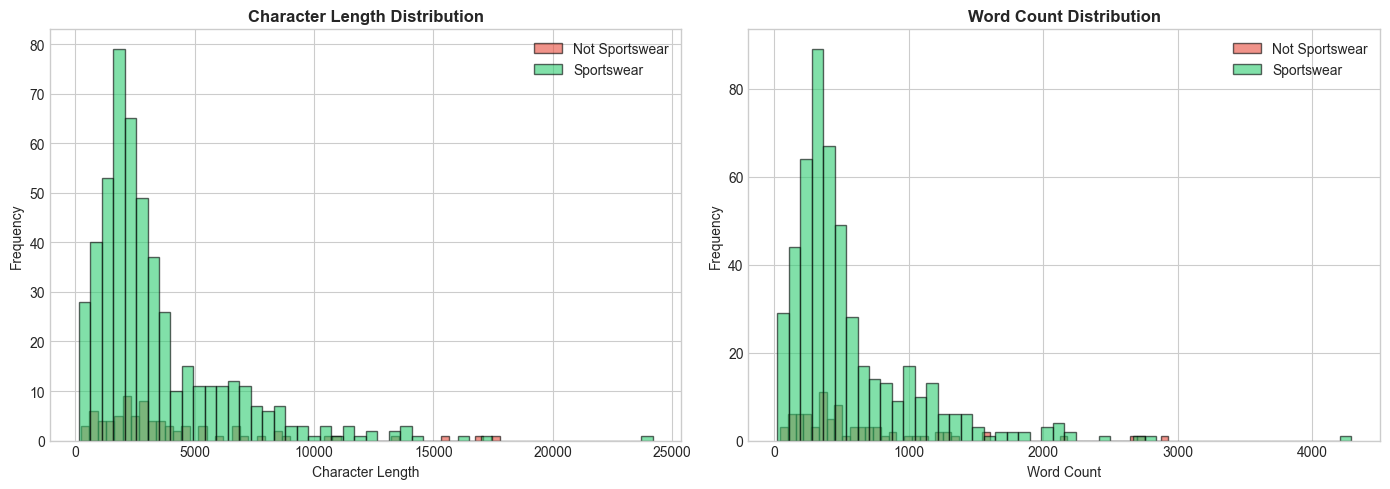

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    save_path='images/fp_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 617
Unique brands: 39

Top 15 brands:
  Nike: 162 (26.3%)
  Lululemon: 56 (9.1%)
  Puma: 38 (6.2%)
  Adidas: 36 (5.8%)
  Vans: 31 (5.0%)
  Hoka: 31 (5.0%)
  New Balance: 22 (3.6%)
  Anta: 21 (3.4%)
  Patagonia: 21 (3.4%)
  Timberland: 20 (3.2%)
  Skechers: 19 (3.1%)
  Reebok: 16 (2.6%)
  Converse: 15 (2.4%)
  Black Diamond: 12 (1.9%)
  ASICS: 11 (1.8%)

Brand distribution by is_sportswear:
  Class 0: 80 mentions, top: Vans (14), Black Diamond (11), Puma (10)
  Class 1: 537 mentions, top: Nike (162), Lululemon (56), Adidas (36)


Figure saved to images/fp_brand_dist.png


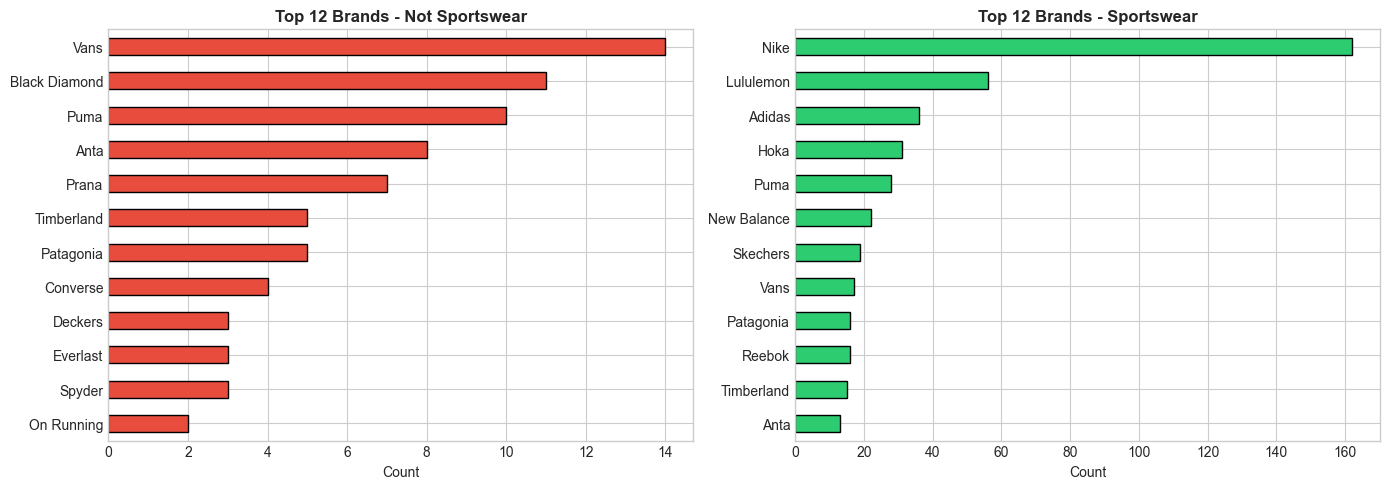

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/fp_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  company: 140
  puma: 86
  curtains: 86
  pvc: 85
  gold: 81
  over: 80
  diamond: 76
  out: 75
  black: 75
  like: 68
  looking: 66
  group: 66
  radisson: 64
  across: 62
  year: 61

Top 15 words for class_1:
  nike: 1,418
  company: 839
  year: 712
  brand: 653
  lululemon: 638
  running: 591
  like: 538
  out: 518
  shoe: 496
  stock: 493
  quarter: 457
  shares: 451
  shoes: 450
  over: 447
  price: 445


In [15]:
# Look at some false positive examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVE ARTICLES (from training data)")
print("="*60)

fp_train = train_df[train_df[TARGET_COL] == 0]
if len(fp_train) >= 3:
    fp_samples = fp_train.sample(3, random_state=RANDOM_STATE)
else:
    fp_samples = fp_train

for _, row in fp_samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'fp_reason' in row and pd.notna(row['fp_reason']):
        print(f"Reason: {row['fp_reason']}")
    print("-" * 40)


SAMPLE FALSE POSITIVE ARTICLES (from training data)

Brands: ['Patagonia']
Title: 5 foreign tourists found dead after going missing in Chile Patagonia region...
Reason: Patagonia: Article is about the Patagonia geographic region in southern Chile, specifically Torres del Paine National Park, not Patagonia the outdoor apparel company
----------------------------------------

Brands: ['Anta']
Title: Rebels loom large over Congress , BJP in Anta bypoll...
Reason: Anta: Article is about Anta constituency/region in Indian politics and a bypoll election, not Anta sportswear company
----------------------------------------

Brands: ['Everlast']
Title: New Liverpool Everlast Gym membership details , pricing and opening hours...
Reason: Everlast: Article is about Everlast Gyms, a fitness center chain, not Everlast sporting goods/boxing equipment company
----------------------------------------


## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the training data with a baseline Logistic Regression classifier. This helps us select the best approach before moving to model selection in the next notebook.

In [16]:
# Define feature engineering approaches to compare
fe_configs = {
    'tfidf_word': {
        'method': 'tfidf_word',
        'max_features': 10000,
        'ngram_range': (1, 2),
        'sublinear_tf': True,
    },
    'tfidf_lsa': {
        'method': 'tfidf_lsa',
        'max_features': 10000,
        'lsa_n_components': 100,
    },
    'doc2vec': {
        'method': 'doc2vec',
        'doc2vec_vector_size': 100,
        'doc2vec_min_count': 2,
        'doc2vec_epochs': 40,
        'doc2vec_dm': 1,
    },
    'sentence_transformer': {
        'method': 'sentence_transformer',
        'sentence_model_name': 'all-MiniLM-L6-v2',
    },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
    },
    'sentence_transformer_ner_vocab': {
        'method': 'sentence_transformer_ner_vocab',
        'sentence_model_name': 'all-MiniLM-L6-v2',
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")

Feature Engineering Approaches to Compare:
  tfidf_word: tfidf_word
  tfidf_lsa: tfidf_lsa
  doc2vec: doc2vec
  sentence_transformer: sentence_transformer
  sentence_transformer_ner: sentence_transformer_ner
  sentence_transformer_ner_vocab: sentence_transformer_ner_vocab


In [17]:
# Evaluate each feature engineering approach using cross-validation
# Compare with both Logistic Regression and HistGradientBoosting classifiers

from scipy.sparse import issparse

f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define classifiers to benchmark
# Note: HistGradientBoostingClassifier supports class_weight='balanced' for imbalanced data
# but requires dense arrays (not sparse matrices)
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            solver='saga'
        ),
        'requires_dense': False,  # LR handles sparse matrices
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight='balanced',
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,  # HGB requires dense arrays
    },
}

fe_results = []

for name, config in fe_configs.items():
    print(f"Evaluating {name}...")
    
    # Create transformer
    transformer = FPFeatureTransformer(**config, random_state=RANDOM_STATE)
    
    # Fit and transform training data
    X_train_fe = transformer.fit_transform(X_train)
    
    print(f"  Feature shape: {X_train_fe.shape}, sparse: {issparse(X_train_fe)}")
    
    # Evaluate with each classifier
    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        
        # Convert to dense if classifier requires it
        if clf_info['requires_dense'] and issparse(X_train_fe):
            X_for_cv = X_train_fe.toarray()
        else:
            X_for_cv = X_train_fe
        
        # Cross-validation
        cv_scores = cross_validate(
            clf, X_for_cv, y_train,
            cv=cv,
            scoring={
                'f2': f2_scorer,
                'recall': 'recall',
                'precision': 'precision',
            },
            return_train_score=False
        )
        
        result = {
            'name': name,
            'classifier': clf_name,
            'n_features': X_train_fe.shape[1],
            'cv_f2': cv_scores['test_f2'].mean(),
            'cv_f2_std': cv_scores['test_f2'].std(),
            'cv_recall': cv_scores['test_recall'].mean(),
            'cv_precision': cv_scores['test_precision'].mean(),
        }
        fe_results.append(result)
        
        print(f"  [{clf_name}] CV F2: {result['cv_f2']:.4f} (+/- {result['cv_f2_std']:.4f})")

Evaluating tfidf_word...


  Feature shape: (582, 10000), sparse: True
  [LogisticRegression] CV F2: 0.9444 (+/- 0.0157)


  [HistGradientBoosting] CV F2: 0.9279 (+/- 0.0166)
Evaluating tfidf_lsa...


  Feature shape: (582, 100), sparse: False
  [LogisticRegression] CV F2: 0.9168 (+/- 0.0231)


  [HistGradientBoosting] CV F2: 0.9521 (+/- 0.0113)
Evaluating doc2vec...


  Feature shape: (582, 100), sparse: False


  [LogisticRegression] CV F2: 0.9112 (+/- 0.0074)


  [HistGradientBoosting] CV F2: 0.9548 (+/- 0.0116)
Evaluating sentence_transformer...


  Feature shape: (582, 384), sparse: False


  [LogisticRegression] CV F2: 0.9034 (+/- 0.0222)


  [HistGradientBoosting] CV F2: 0.9569 (+/- 0.0134)
Evaluating sentence_transformer_ner...


  Feature shape: (582, 390), sparse: False


  [LogisticRegression] CV F2: 0.9017 (+/- 0.0262)


  [HistGradientBoosting] CV F2: 0.9613 (+/- 0.0122)
Evaluating sentence_transformer_ner_vocab...


  Feature shape: (582, 404), sparse: False


  [LogisticRegression] CV F2: 0.8765 (+/- 0.0379)


  [HistGradientBoosting] CV F2: 0.9497 (+/- 0.0035)


In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by LogisticRegression F2 score
display_df = fe_df[fe_df['classifier'] == 'LogisticRegression'].set_index('name')
display_df = display_df.sort_values('cv_f2', ascending=False)
print("\nLogistic Regression Results:")
print(display_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

# Display HistGradientBoosting results
hgb_df = fe_df[fe_df['classifier'] == 'HistGradientBoosting'].set_index('name')
hgb_df = hgb_df.sort_values('cv_f2', ascending=False)
print("\nHistGradientBoosting Results:")
print(hgb_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

Logistic Regression Results:
                                n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                         
tfidf_word                           10000  0.944380   0.015714   0.944444   
tfidf_lsa                              100  0.916831   0.023116   0.902778   
doc2vec                                100  0.911226   0.007421   0.904762   
sentence_transformer                   384  0.903419   0.022183   0.884921   
sentence_transformer_ner               390  0.901711   0.026224   0.882937   
sentence_transformer_ner_vocab         404  0.876479   0.037891   0.853175   

                                cv_precision  
name                                          
tfidf_word                          0.944502  
tfidf_lsa                           0.978528  
doc2vec                             0.938791  
sentence_transformer                0.986898  
sentence_transformer_ne

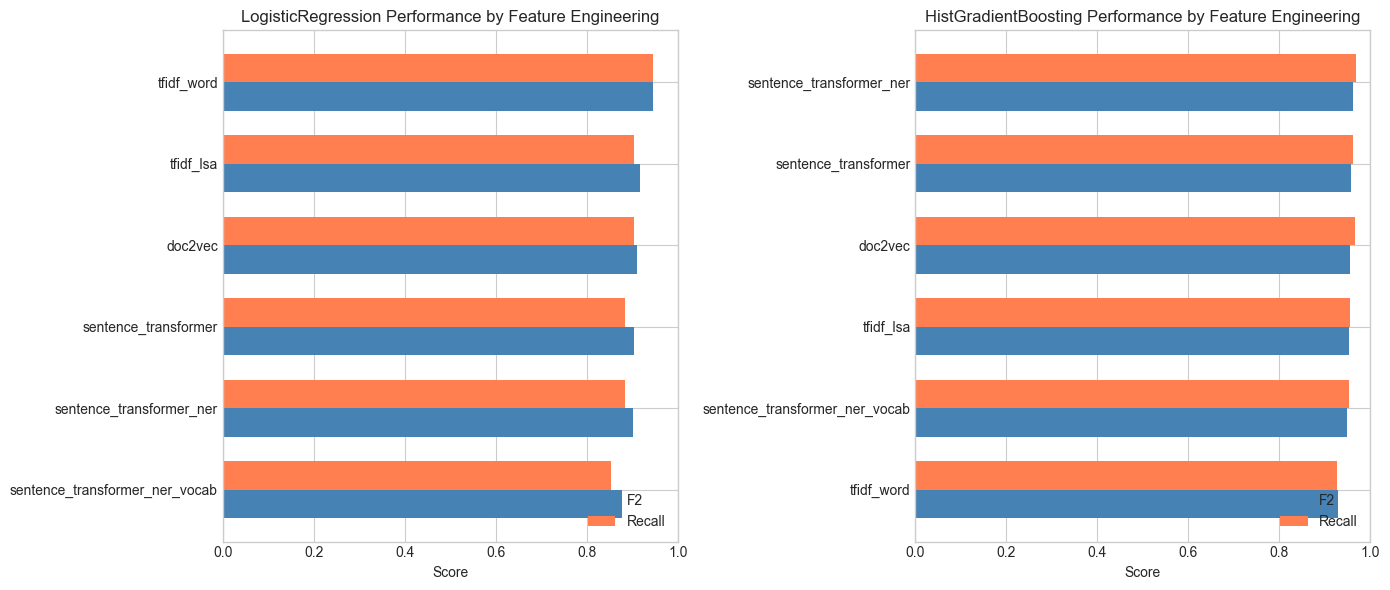

In [19]:
# Visualize comparison - show both classifiers side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, clf_name in enumerate(['LogisticRegression', 'HistGradientBoosting']):
    ax = axes[idx]
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=True)
    
    x = range(len(clf_df))
    width = 0.35
    
    ax.barh([i - width/2 for i in x], clf_df['cv_f2'], width, label='F2', color='steelblue')
    ax.barh([i + width/2 for i in x], clf_df['cv_recall'], width, label='Recall', color='coral')
    
    ax.set_yticks(list(x))
    ax.set_yticklabels(clf_df.index)
    ax.set_xlabel('Score')
    ax.set_title(f'{clf_name} Performance by Feature Engineering')
    ax.legend(loc='lower right')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'fe_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [20]:
# Create the best transformer and fit on training data
best_config = fe_configs[best_fe]
print(f"Selected feature engineering approach: {best_fe}")
print(f"Configuration: {best_config}")

# Create transformer with best configuration
final_transformer = FPFeatureTransformer(**best_config, random_state=RANDOM_STATE)

# Fit on training data
X_train_final = final_transformer.fit_transform(X_train)
print(f"\nFinal feature shape: {X_train_final.shape}")

# Verify by transforming validation data
X_val_final = final_transformer.transform(X_val)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: sentence_transformer_ner
Configuration: {'method': 'sentence_transformer_ner', 'sentence_model_name': 'all-MiniLM-L6-v2'}



Final feature shape: (582, 390)


Validation feature shape: (194, 390)


In [21]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'fp_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'fp_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json


## 7. Summary

In [22]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Sportswear: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - False Positive: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")
print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
print(f"  - Features: {int(best_row['n_features'])}")
print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'fp_feature_transformer.joblib'}")
print(f"  - {MODELS_DIR / 'fp_feature_config.json'}")
print(f"  - {MODELS_DIR / 'fp_fe_comparison.json'}")
print(f"\nNext: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)


NOTEBOOK SUMMARY

Dataset: 971 articles
  - Training: 582 (59.9%)
  - Validation: 194 (20.0%)

Class distribution (training):
  - Sportswear: 504 (86.6%)
  - False Positive: 78 (13.4%)

Best Feature Engineering: sentence_transformer_ner
  - Best Classifier: HistGradientBoosting
  - CV F2 Score: 0.9613
  - Features: 390

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json

Next: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
